In [1]:
# Imports
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
from matplotlib import cm, colors
import xesmf

In [2]:
import warnings
warnings.simplefilter("ignore", RuntimeWarning)

In [3]:
# ENSO years
EN = [1982, 1986, 1987, 1991, 1994, 1997, 2002, 2004, 2006, 2009, 2014, 2015, 2018]

LN = [1983, 1984, 1988, 1995, 1996, 1998, 1999, 2000, 2005, 2007, 2010, 2011, 2017, 2020, 2021, 2022]

NN = [1981, 1985, 1989, 1990, 1992, 1993, 2001, 2003, 2008, 2012, 2013, 2016, 2019]

In [4]:
# AGCD landmask
landmask = xr.open_dataset('/g/data/w40/asp561/agcd/mask_australia_0.05deg.nc').landmask

In [5]:
# AGCD data (v2 for precip) 
file_pattern = "/g/data/zv2/agcd/v2-0-2/precip/total/r005/01month/agcd_v2_precip_total_r005_monthly_{}.nc"
# Generate list of file paths for years 1960-2022
years = range(1981, 2023)  
paths = [file_pattern.format(year) for year in years]
# Open dataset 
precip = xr.open_mfdataset(paths, combine='nested', concat_dim='time', chunks={'time':12, 'lat':'auto', 'lon':'auto'}).precip

In [6]:
# SON anomalies
clim = precip.groupby('time.month').mean()
anom = precip - clim.sel(month=precip['time.month'])
anom_seasonal = anom.resample(time='QS-SEP').reduce(np.mean)
anom_son = anom_seasonal.where(anom_seasonal['time'].dt.month == 9, drop=True).where(landmask.data == 1)

In [7]:
# Anomalies in ENSO years
anom_son_EN = anom_son.sel(time=anom_son['time'].dt.year.isin(EN)).chunk(chunks={'time':-1, 'lat':-1, 'lon':-1})
anom_son_LN = anom_son.sel(time=anom_son['time'].dt.year.isin(LN)).chunk(chunks={'time':-1, 'lat':-1, 'lon':-1})
anom_son_NN = anom_son.sel(time=anom_son['time'].dt.year.isin(NN)).chunk(chunks={'time':-1, 'lat':-1, 'lon':-1})

In [8]:
# Composites 
comp_son_EN = anom_son_EN.mean(dim='time')
comp_son_LN = anom_son_LN.mean(dim='time')
comp_son_NN = anom_son_NN.mean(dim='time')

In [9]:
# Standard deviation
comp_son_EN_std = anom_son_EN.std(dim='time')
comp_son_LN_std = anom_son_LN.std(dim='time')
comp_son_NN_std = anom_son_NN.std(dim='time')

In [10]:
comp_son_EN_std_norm = comp_son_EN_std / abs(comp_son_EN)
comp_son_LN_std_norm = comp_son_LN_std / abs(comp_son_LN)
comp_son_NN_std_norm = comp_son_NN_std / abs(comp_son_NN)

In [11]:
def format_gridlines(ax, top_labels=False, bottom_labels=False, left_labels=False, right_labels=False):
    
    import cartopy.crs as ccrs
    from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
    
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.75, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = top_labels
    gl.bottom_labels = bottom_labels
    gl.right_labels = right_labels
    gl.left_labels = left_labels
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

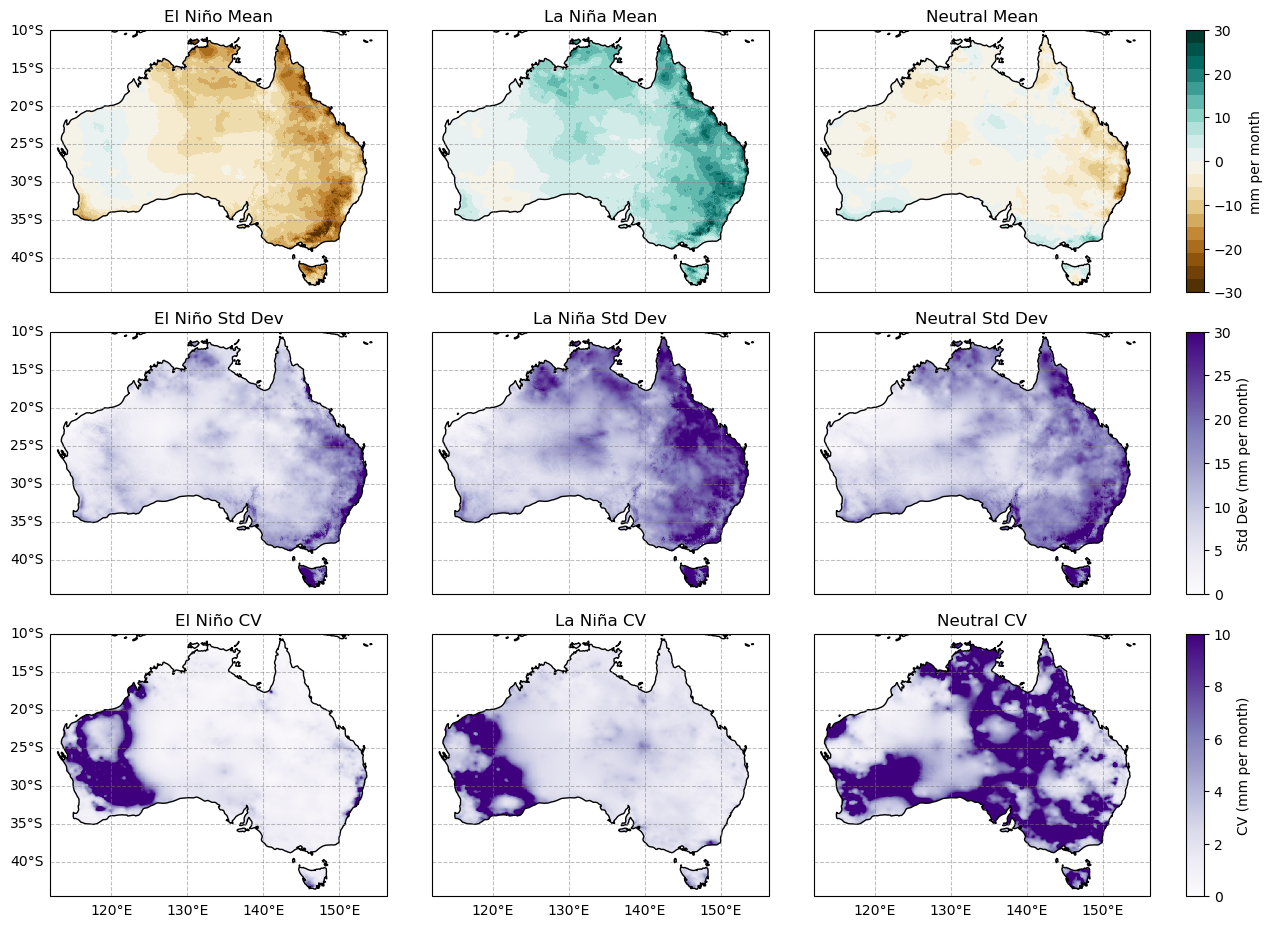

In [12]:
fig = plt.figure(figsize=(15, 11.25))  
gs = gridspec.GridSpec(3, 4, wspace=0.1, hspace=0.15, width_ratios=[1, 1, 1, 0.05])
cmap_pr = plt.get_cmap('BrBG', 20)

# Row 1: Mean Composites
ax = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
im = comp_son_EN.plot(ax=ax, cmap=cmap_pr, vmin=-30, vmax=30, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('El Niño Mean')
ax = format_gridlines(ax, left_labels=True, bottom_labels=False) 

ax = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
im = comp_son_LN.plot(ax=ax, cmap=cmap_pr, vmin=-30, vmax=30, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('La Niña Mean')
ax = format_gridlines(ax)

ax = fig.add_subplot(gs[0, 2], projection=ccrs.PlateCarree())
im = comp_son_NN.plot(ax=ax, cmap=cmap_pr, vmin=-30, vmax=30, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('Neutral Mean')
ax = format_gridlines(ax) 

# First colorbar for precip
cax = plt.subplot(gs[0, 3])
cbar = plt.colorbar(im, cax)
cbar.ax.set_ylabel('mm per month');

# Row 2: Standard Deviation Maps
ax = fig.add_subplot(gs[1, 0], projection=ccrs.PlateCarree())
im = comp_son_EN_std.plot(ax=ax, cmap="Purples", vmin=0, vmax=30, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('El Niño Std Dev')
ax = format_gridlines(ax, left_labels=True) 

ax = fig.add_subplot(gs[1, 1], projection=ccrs.PlateCarree())
im = comp_son_LN_std.plot(ax=ax, cmap="Purples", vmin=0, vmax=30, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('La Niña Std Dev')
ax = format_gridlines(ax)

ax = fig.add_subplot(gs[1, 2], projection=ccrs.PlateCarree())
im = comp_son_NN_std.plot(ax=ax, cmap="Purples", vmin=0, vmax=30, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('Neutral Std Dev')
ax = format_gridlines(ax) 

# Second colorbar for std deviation
cax2 = plt.subplot(gs[1, 3])
cbar = plt.colorbar(im, cax2)
cbar.ax.set_ylabel('Std Dev (mm per month)');

# Row 3: Normalised standard deviation maps
ax = fig.add_subplot(gs[2, 0], projection=ccrs.PlateCarree())
im = comp_son_EN_std_norm.plot(ax=ax, cmap="Purples", vmin=0, vmax=10, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('El Niño CV')
ax = format_gridlines(ax, left_labels=True, bottom_labels=True) 

ax = fig.add_subplot(gs[2, 1], projection=ccrs.PlateCarree())
im = comp_son_LN_std_norm.plot(ax=ax, cmap="Purples", vmin=0, vmax=10, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('La Niña CV')
ax = format_gridlines(ax, bottom_labels=True)

ax = fig.add_subplot(gs[2, 2], projection=ccrs.PlateCarree())
im = comp_son_NN_std_norm.plot(ax=ax, cmap="Purples", vmin=0, vmax=10, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('Neutral CV')
ax = format_gridlines(ax, bottom_labels=True)

# Third colorbar for std deviation normalised 
cax3 = plt.subplot(gs[2, 3])
cbar = plt.colorbar(im, cax3)
cbar.ax.set_ylabel('CV (mm per month)');

In [13]:
# Values for median, 5th, 25th, 75th, 95th percentile of rainfall (whole period?)
quantiles_total = precip.quantile([0.05, 0.1, 0.25, 0.33, 0.5, 0.66, 0.75, 0.9, 0.95], dim='time').where(landmask.data == 1)

In [14]:
# Custon cbar
cmap_brbg = plt.get_cmap('BrBG')
cmap_green = colors.ListedColormap(cmap_brbg(np.linspace(0.5, 1, 10)))
pr_boundaries = [0, 5, 10, 20, 35, 50, 70, 100, 140, 200]  
pr_norm = colors.BoundaryNorm(pr_boundaries, cmap_green.N)

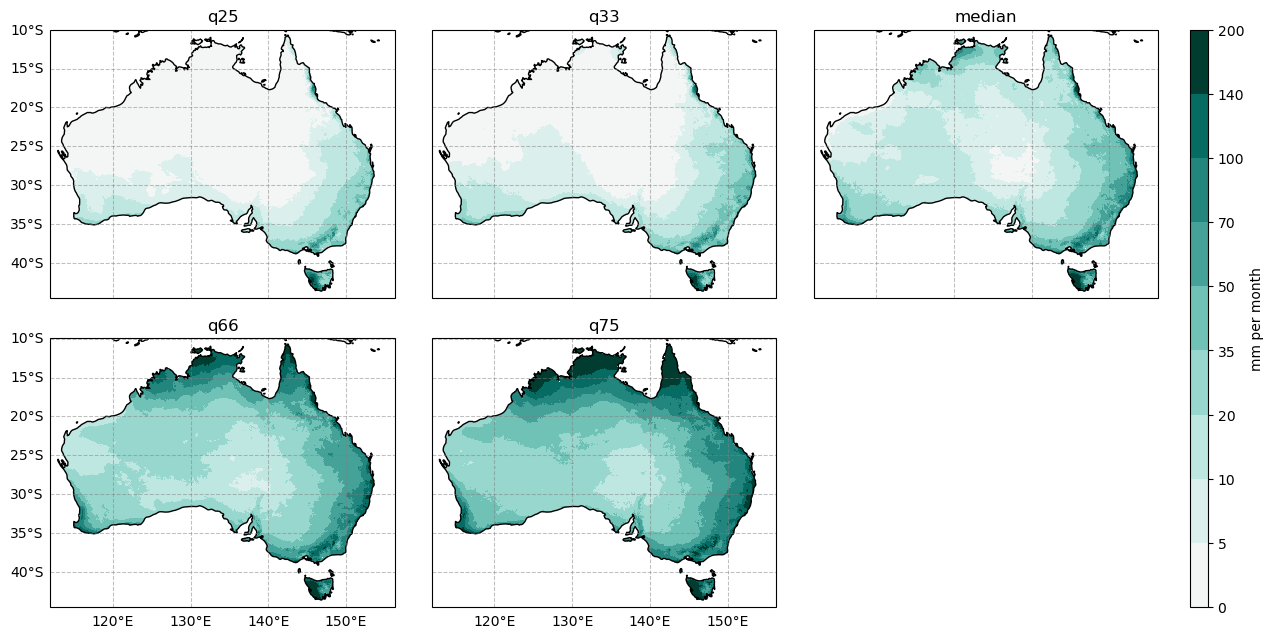

In [15]:
fig = plt.figure(figsize=(15, 7.5))  
gs = gridspec.GridSpec(2, 4, wspace=0.1, hspace=0.15, width_ratios=[1, 1, 1, 0.05])

ax = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
im = quantiles_total.sel(quantile=0.25).plot(ax=ax, cmap=cmap_green, norm=pr_norm, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('q25')
ax = format_gridlines(ax, left_labels=True) 

ax = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
im = quantiles_total.sel(quantile=0.33).plot(ax=ax, cmap=cmap_green, norm=pr_norm, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('q33')
ax = format_gridlines(ax)

ax = fig.add_subplot(gs[0, 2], projection=ccrs.PlateCarree())
im = quantiles_total.sel(quantile=0.5).plot(ax=ax, cmap=cmap_green, norm=pr_norm, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('median')
ax = format_gridlines(ax) 

ax = fig.add_subplot(gs[1, 0], projection=ccrs.PlateCarree())
im = quantiles_total.sel(quantile=0.66).plot(ax=ax, cmap=cmap_green, norm=pr_norm, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('q66')
ax = format_gridlines(ax, left_labels=True, bottom_labels=True) 

ax = fig.add_subplot(gs[1, 1], projection=ccrs.PlateCarree())
im = quantiles_total.sel(quantile=0.75).plot(ax=ax, cmap=cmap_green, norm=pr_norm, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('q75')
ax = format_gridlines(ax, bottom_labels=True) 

cax = plt.subplot(gs[:, 3])
cbar = plt.colorbar(im, cax, ticks=pr_boundaries)
cbar.ax.set_ylabel('mm per month');

In [16]:
# Quantiles for anomalies
quantiles = anom_son.quantile([0.05, 0.1, 0.25, 0.33, 0.5, 0.66, 0.75, 0.9, 0.95], dim='time').chunk(chunks={'lat':-1, 'lon':-1})

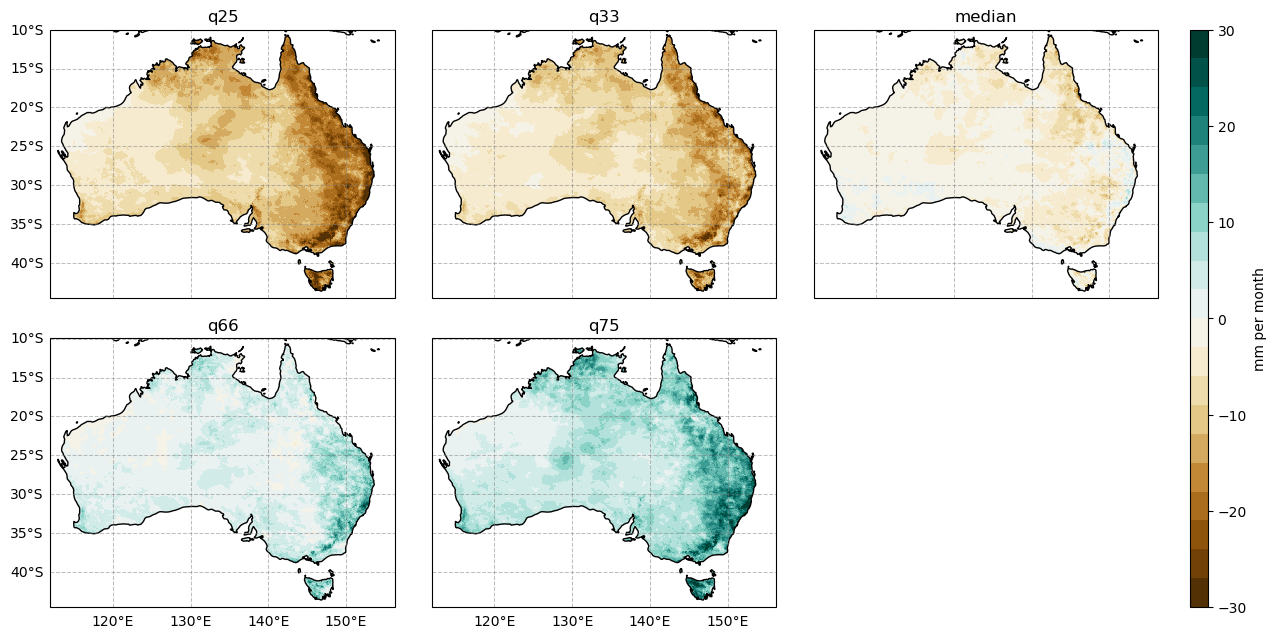

In [17]:
fig = plt.figure(figsize=(15, 7.5))  
gs = gridspec.GridSpec(2, 4, wspace=0.1, hspace=0.15, width_ratios=[1, 1, 1, 0.05])
vmin = -30
vmax = 30

ax = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
im = quantiles.sel(quantile=0.25).plot(ax=ax, cmap=cmap_pr, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('q25')
ax = format_gridlines(ax, left_labels=True) 

ax = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
im = quantiles.sel(quantile=0.33).plot(ax=ax, cmap=cmap_pr, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('q33')
ax = format_gridlines(ax)

ax = fig.add_subplot(gs[0, 2], projection=ccrs.PlateCarree())
im = quantiles.sel(quantile=0.5).plot(ax=ax, cmap=cmap_pr, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('median')
ax = format_gridlines(ax) 

ax = fig.add_subplot(gs[1, 0], projection=ccrs.PlateCarree())
im = quantiles.sel(quantile=0.66).plot(ax=ax, cmap=cmap_pr, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('q66')
ax = format_gridlines(ax, left_labels=True, bottom_labels=True) 

ax = fig.add_subplot(gs[1, 1], projection=ccrs.PlateCarree())
im = quantiles.sel(quantile=0.75).plot(ax=ax, cmap=cmap_pr, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('q75')
ax = format_gridlines(ax, bottom_labels=True) 

cax = plt.subplot(gs[:, 3])
cbar = plt.colorbar(im, cax)
cbar.ax.set_ylabel('mm per month');

In [18]:
# Calculate cdf at each grid point 
def empirical_cdf(data):
    sorted_data = np.sort(data)
    cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    return sorted_data, cdf

In [19]:
sorted_EN, cdf_EN = xr.apply_ufunc(
    empirical_cdf, 
    anom_son_EN, 
    input_core_dims=[["time"]],
    output_core_dims=[["time"], ["time"]], 
    vectorize=True,
    dask="parallelized"
)

In [20]:
sorted_LN, cdf_LN = xr.apply_ufunc(
    empirical_cdf, 
    anom_son_LN, 
    input_core_dims=[["time"]],
    output_core_dims=[["time"], ["time"]], 
    vectorize=True,
    dask="parallelized"
)

In [21]:
sorted_NN, cdf_NN = xr.apply_ufunc(
    empirical_cdf, 
    anom_son_NN, 
    input_core_dims=[["time"]],
    output_core_dims=[["time"], ["time"]], 
    vectorize=True,
    dask="parallelized"
)

In [22]:
# Calculate FAR for median, 5th, 25th, 75th, and 95th percentile
# FAR = 1 - (P_N / P_A)
# P_A is probability when active ENSO, and P_N is probability when neutral 

In [23]:
# Extract median rainfall values (and other quantiles) for each grid point
q10_rainfall = quantiles.sel(quantile=0.10)
q25_rainfall = quantiles.sel(quantile=0.25)
q33_rainfall = quantiles.sel(quantile=0.33)
median_rainfall = quantiles.sel(quantile=0.5)
q66_rainfall = quantiles.sel(quantile=0.66)
q75_rainfall = quantiles.sel(quantile=0.75)
q90_rainfall = quantiles.sel(quantile=0.90)

In [24]:
def get_probability_exceed(cdf, data_values, threshold):
    """Returns probability P(X ≥ threshold) using the CDF."""
    idx = np.searchsorted(data_values, threshold, side='right') - 1
    idx = np.clip(idx, 0, len(data_values) - 1)  # Ensure valid index
    return 1 - cdf[..., idx] 

def get_probability_deficit(cdf, data_values, threshold):
    """Returns probability P(X ≤ threshold) using the CDF."""
    idx = np.searchsorted(data_values, threshold, side='right') - 1
    idx = np.clip(idx, 0, len(data_values) - 1)  # Ensure valid index
    return cdf[..., idx]

def spatial_probability_exceed(cdf, anom_data, threshold):
    
    P = xr.apply_ufunc(
        get_probability_exceed, cdf, anom_data, threshold,
        input_core_dims=[["time"], ["time"], []],  # Match time dimension
        output_core_dims=[[]],  # Remove time dim
        vectorize=True,
        dask="parallelized"
    )
    return P

def spatial_probability_deficit(cdf, anom_data, threshold):
    
    P = xr.apply_ufunc(
        get_probability_deficit, cdf, anom_data, threshold,
        input_core_dims=[["time"], ["time"], []],  # Match time dimension
        output_core_dims=[[]],  # Remove time dim
        vectorize=True,
        dask="parallelized"
    )
    return P

#### Assumption that El Niño is dry based off composites - Look at rainfall probabilities below threshold 

In [25]:
P_EN_10th = spatial_probability_deficit(cdf_EN, anom_son_EN, q10_rainfall)
P_NN_10th = spatial_probability_deficit(cdf_NN, anom_son_NN, q10_rainfall)

P_EN_25th = spatial_probability_deficit(cdf_EN, anom_son_EN, q25_rainfall)
P_NN_25th = spatial_probability_deficit(cdf_NN, anom_son_NN, q25_rainfall)

P_EN_33th = spatial_probability_deficit(cdf_EN, anom_son_EN, q33_rainfall)
P_NN_33th = spatial_probability_deficit(cdf_NN, anom_son_NN, q33_rainfall)

P_EN_median_below = spatial_probability_deficit(cdf_EN, anom_son_EN, median_rainfall)
P_NN_median_below = spatial_probability_deficit(cdf_NN, anom_son_NN, median_rainfall)

#### Assumption that La Niña is wet based off composites - Look at rainfall probabilities above threshold 

In [26]:
P_LN_median_above = spatial_probability_exceed(cdf_LN, anom_son_LN, median_rainfall)
P_NN_median_above = spatial_probability_exceed(cdf_NN, anom_son_NN, median_rainfall)

P_LN_66th = spatial_probability_exceed(cdf_LN, anom_son_LN, q66_rainfall)
P_NN_66th = spatial_probability_exceed(cdf_NN, anom_son_NN, q66_rainfall)

P_LN_75th = spatial_probability_exceed(cdf_LN, anom_son_LN, q75_rainfall)
P_NN_75th = spatial_probability_exceed(cdf_NN, anom_son_NN, q75_rainfall)

P_LN_90th = spatial_probability_exceed(cdf_LN, anom_son_LN, q90_rainfall)
P_NN_90th = spatial_probability_exceed(cdf_NN, anom_son_NN, q90_rainfall)

#### Calculate FAR

In [27]:
FAR_EN_10th = 1 - (P_NN_10th / P_EN_10th)
FAR_EN_25th = 1 - (P_NN_25th / P_EN_25th)
FAR_EN_33th = 1 - (P_NN_33th / P_EN_33th)
FAR_EN_med_below = 1 - (P_NN_median_below / P_EN_median_below)

In [28]:
FAR_LN_med_above = 1 - (P_NN_median_above / P_LN_median_above)
FAR_LN_66th = 1 - (P_NN_66th / P_LN_66th)
FAR_LN_75th = 1 - (P_NN_75th / P_LN_75th)
FAR_LN_90th = 1 - (P_NN_90th / P_LN_90th)

#### La Niña plot: exceeding, median, 75th, 90th and 95th percentile

In [29]:
# FAR colorbar
colors = [
    "#0570b0", "#3690c0", "#74a9cf", "#a6bddb", "#d0d1e6",  
    "#ffffcc", "#ffeda0", "#fed976", "#feb24c", "#fd8d3c",
    "#fc6631", "#f03b20", "#e31a1c", "#bd0026", "#e7298a"
]

bounds_prob = np.concatenate([np.linspace(-1, 0, 6), np.linspace(0.1, 1, 10)]) 
cmap_prob = mcolors.ListedColormap(colors)
norm_prob = mcolors.BoundaryNorm(bounds_prob, cmap_prob.N)

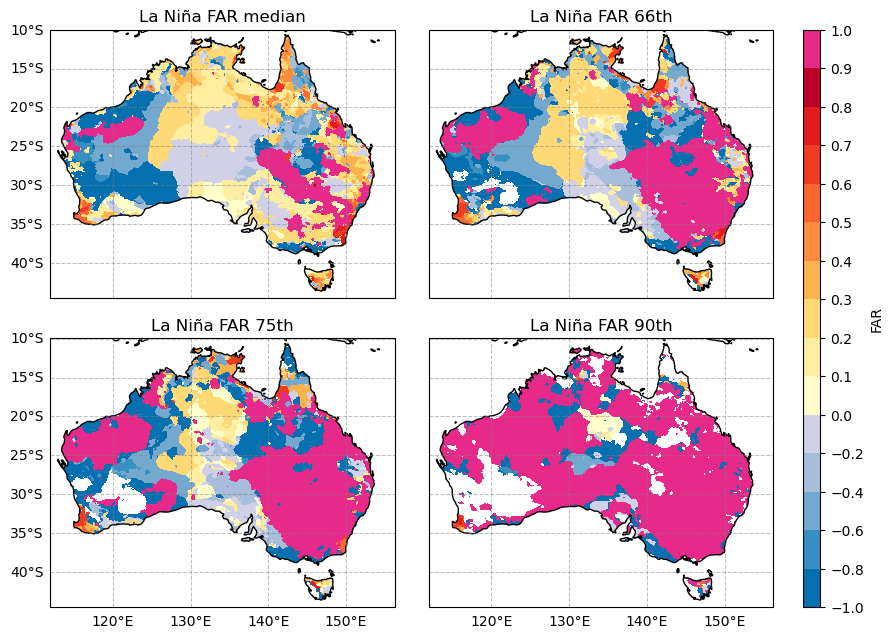

In [30]:
fig = plt.figure(figsize=(10, 7.5))  
gs = gridspec.GridSpec(2, 3, wspace=0.1, hspace=0.15, width_ratios=[1, 1, 0.05])

ax = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
im = FAR_LN_med_above.plot(ax=ax, cmap=cmap_prob, norm=norm_prob, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('La Niña FAR median')
ax = format_gridlines(ax, left_labels=True) 

ax = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
im = FAR_LN_66th.plot(ax=ax, cmap=cmap_prob, norm=norm_prob, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('La Niña FAR 66th')
ax = format_gridlines(ax)

ax = fig.add_subplot(gs[1, 0], projection=ccrs.PlateCarree())
im = FAR_LN_75th.plot(ax=ax, cmap=cmap_prob, norm=norm_prob, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('La Niña FAR 75th')
ax = format_gridlines(ax, left_labels=True, bottom_labels=True)

ax = fig.add_subplot(gs[1, 1], projection=ccrs.PlateCarree())
im = FAR_LN_90th.plot(ax=ax, cmap=cmap_prob, norm=norm_prob, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('La Niña FAR 90th')
ax = format_gridlines(ax, bottom_labels=True)

cax = plt.subplot(gs[:, 2])
cbar = plt.colorbar(im, cax, ticks=bounds_prob)
cbar.ax.set_ylabel('FAR');

#### El Niño plot: deficit below median, 25th and 5th percentile

In [31]:
# replace zero with nan - for some reason ocean is zero
FAR_EN_med_below = FAR_EN_med_below.where(FAR_EN_med_below != 0, np.nan)
FAR_EN_33th = FAR_EN_33th.where(FAR_EN_33th != 0, np.nan)
FAR_EN_25th = FAR_EN_25th.where(FAR_EN_25th != 0, np.nan)
FAR_EN_10th = FAR_EN_10th.where(FAR_EN_10th != 0, np.nan)

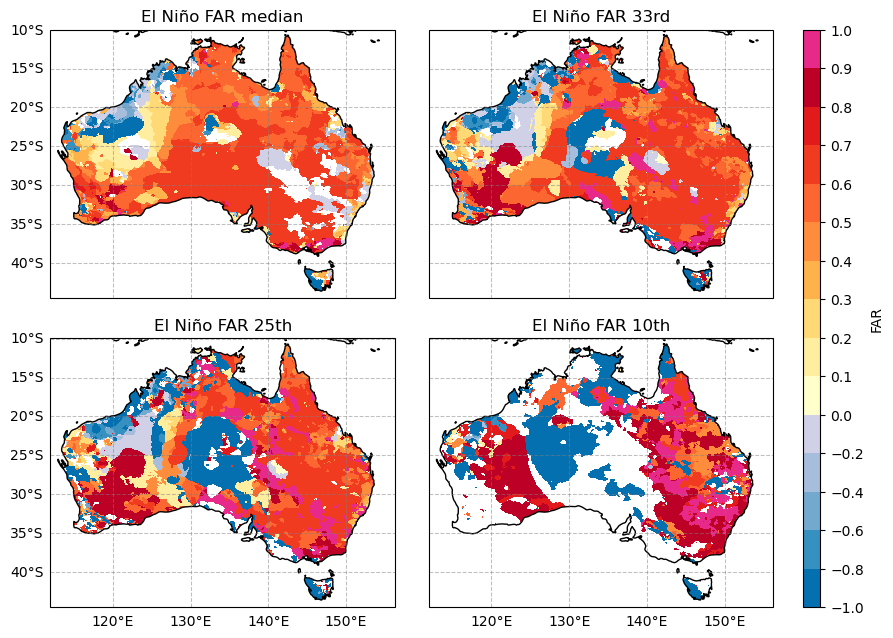

In [32]:
fig = plt.figure(figsize=(10, 7.5))  
gs = gridspec.GridSpec(2, 3, wspace=0.1, hspace=0.15, width_ratios=[1, 1, 0.05])

ax = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
im = FAR_EN_med_below.plot(ax=ax, cmap=cmap_prob, norm=norm_prob, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('El Niño FAR median')
ax = format_gridlines(ax, left_labels=True) 

ax = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
im = FAR_EN_33th.plot(ax=ax, cmap=cmap_prob, norm=norm_prob, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('El Niño FAR 33rd')
ax = format_gridlines(ax)

ax = fig.add_subplot(gs[1, 0], projection=ccrs.PlateCarree())
im = FAR_EN_25th.plot(ax=ax, cmap=cmap_prob, norm=norm_prob, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('El Niño FAR 25th')
ax = format_gridlines(ax, left_labels=True, bottom_labels=True)

ax = fig.add_subplot(gs[1, 1], projection=ccrs.PlateCarree())
im = FAR_EN_10th.plot(ax=ax, cmap=cmap_prob, norm=norm_prob, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('El Niño FAR 10th')
ax = format_gridlines(ax, bottom_labels=True)

cax = plt.subplot(gs[:, 2])
cbar = plt.colorbar(im, cax, ticks=bounds_prob)
cbar.ax.set_ylabel('FAR');

#### Calculate RR for median, 5th, 10th 25th, 75th, 90th, and 95th percentile?

In [ ]:
# RR = PA / PN
# PA = ENSO active (EN or LN)
# PN = ENSO neutral (NN) 

In [33]:
RR_EN_10th = P_EN_10th / P_NN_10th
RR_EN_25th = P_EN_25th / P_NN_25th
RR_EN_33th = P_EN_33th / P_NN_33th
RR_EN_med_below = P_EN_median_below / P_NN_median_below

In [34]:
RR_LN_med_above = P_LN_median_above / P_NN_median_above
RR_LN_66th = P_LN_66th / P_NN_66th
RR_LN_75th = P_LN_75th / P_NN_75th
RR_LN_90th = P_LN_90th / P_NN_90th

#### La Niña plot 

In [35]:
# Risk colorbar
colors = [
    "#6baed6", "#bdd7e7",  
    "#ffffcc", "#ffeda0", "#fed976", "#feb24c", "#fd8d3c", "#f03b20", "#bd0026", "#e7298a"  
]

cmap_risk = mcolors.ListedColormap(colors)
bounds_risk = np.arange(0, 5.5, 0.5)
norm_risk = mcolors.BoundaryNorm(bounds_risk, cmap_risk.N)

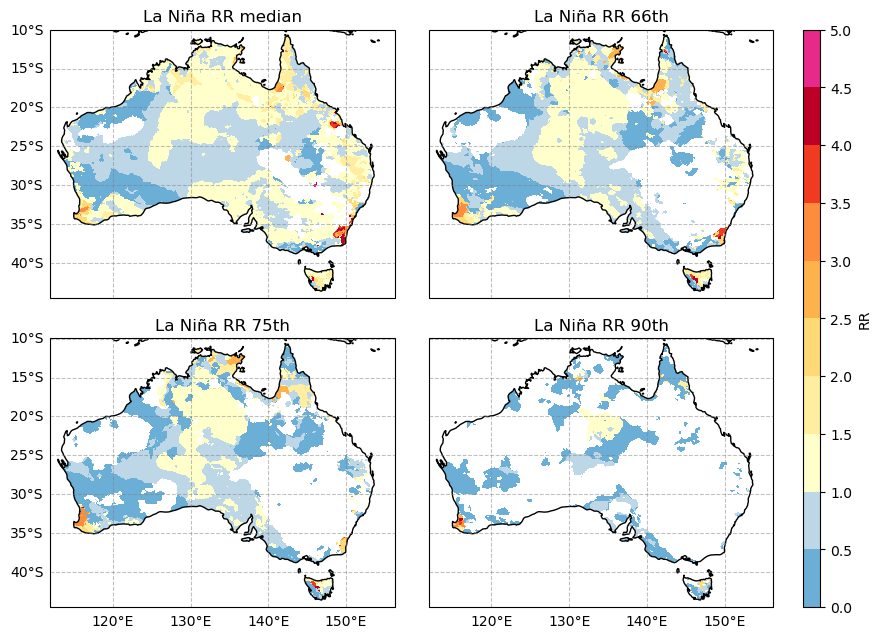

In [36]:
fig = plt.figure(figsize=(10, 7.5))  
gs = gridspec.GridSpec(2, 3, wspace=0.1, hspace=0.15, width_ratios=[1, 1, 0.05])

ax = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
im = RR_LN_med_above.plot(ax=ax, cmap=cmap_risk, norm=norm_risk, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('La Niña RR median')
ax = format_gridlines(ax, left_labels=True) 

ax = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
im = RR_LN_66th.plot(ax=ax, cmap=cmap_risk, norm=norm_risk, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('La Niña RR 66th')
ax = format_gridlines(ax)

ax = fig.add_subplot(gs[1, 0], projection=ccrs.PlateCarree())
im = RR_LN_75th.plot(ax=ax, cmap=cmap_risk, norm=norm_risk, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('La Niña RR 75th')
ax = format_gridlines(ax, left_labels=True, bottom_labels=True)

ax = fig.add_subplot(gs[1, 1], projection=ccrs.PlateCarree())
im = RR_LN_90th.plot(ax=ax, cmap=cmap_risk, norm=norm_risk, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('La Niña RR 90th')
ax = format_gridlines(ax, bottom_labels=True)

cax = plt.subplot(gs[:, 2])
cbar = plt.colorbar(im, cax, ticks=bounds_risk)
cbar.ax.set_ylabel('RR');

#### El Niño plot 

In [37]:
RR_EN_med_below = RR_EN_med_below.where(RR_EN_med_below != 1, np.nan)
RR_EN_33th = RR_EN_33th.where(RR_EN_33th != 1, np.nan)
RR_EN_25th = RR_EN_25th.where(RR_EN_25th != 1, np.nan)
RR_EN_10th = RR_EN_10th.where(RR_EN_10th != 1, np.nan)

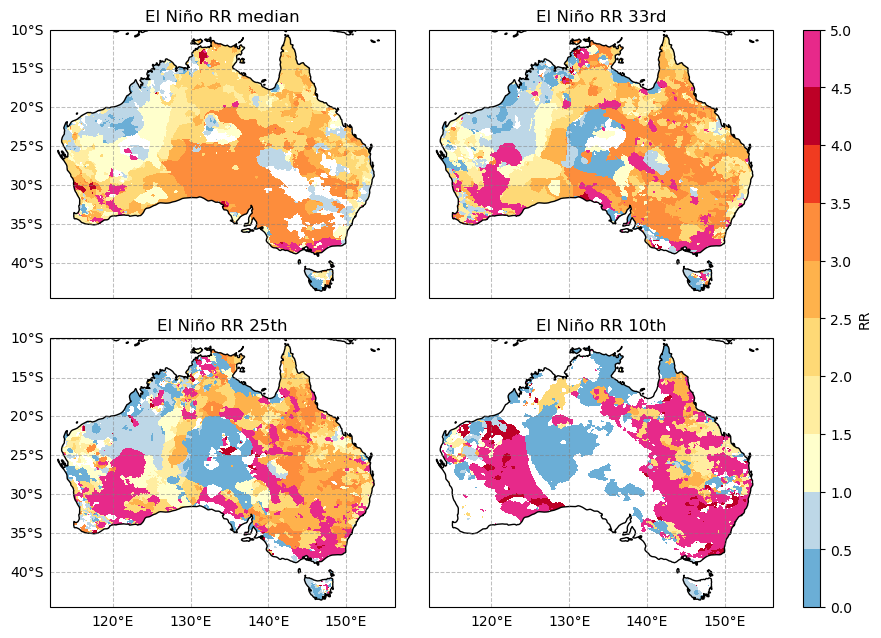

In [38]:
fig = plt.figure(figsize=(10, 7.5))  
gs = gridspec.GridSpec(2, 3, wspace=0.1, hspace=0.15, width_ratios=[1, 1, 0.05])

ax = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
im = RR_EN_med_below.plot(ax=ax, cmap=cmap_risk, norm=norm_risk, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('El Niño RR median')
ax = format_gridlines(ax, left_labels=True) 

ax = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
im = RR_EN_33th.plot(ax=ax, cmap=cmap_risk, norm=norm_risk, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('El Niño RR 33rd')
ax = format_gridlines(ax)

ax = fig.add_subplot(gs[1, 0], projection=ccrs.PlateCarree())
im = RR_EN_25th.plot(ax=ax, cmap=cmap_risk, norm=norm_risk, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('El Niño RR 25th')
ax = format_gridlines(ax, left_labels=True, bottom_labels=True)

ax = fig.add_subplot(gs[1, 1], projection=ccrs.PlateCarree())
im = RR_EN_10th.plot(ax=ax, cmap=cmap_risk, norm=norm_risk, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('El Niño RR 10th')
ax = format_gridlines(ax, bottom_labels=True)

cax = plt.subplot(gs[:, 2])
cbar = plt.colorbar(im, cax, ticks=bounds_risk)
cbar.ax.set_ylabel('RR');

#### Continuous cbar

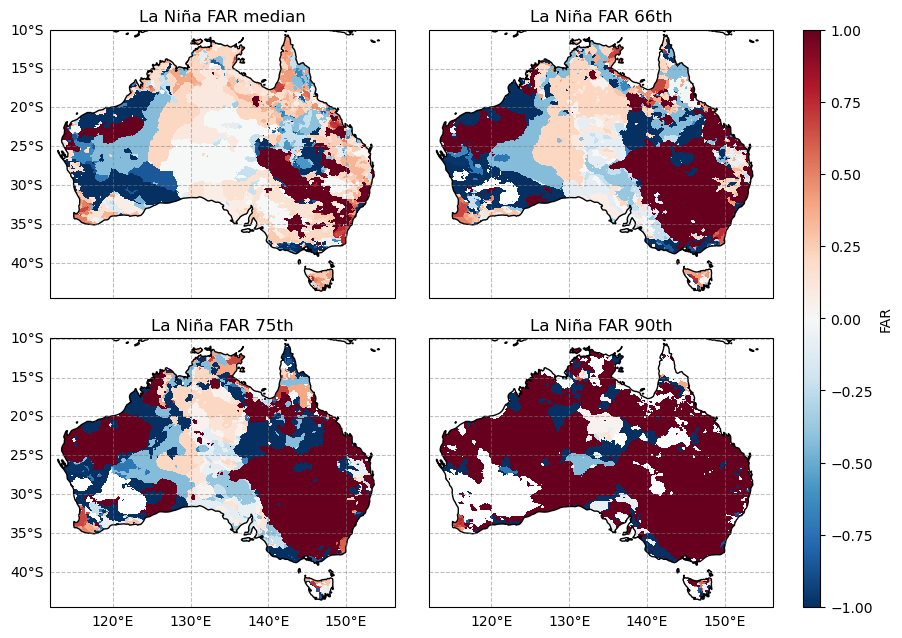

In [40]:
fig = plt.figure(figsize=(10, 7.5))  
gs = gridspec.GridSpec(2, 3, wspace=0.1, hspace=0.15, width_ratios=[1, 1, 0.05])

cmap = 'RdBu_r'
vmin = -1
vmax = 1

ax = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
im = FAR_LN_med_above.plot(ax=ax, cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('La Niña FAR median')
ax = format_gridlines(ax, left_labels=True) 

ax = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
im = FAR_LN_66th.plot(ax=ax, cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('La Niña FAR 66th')
ax = format_gridlines(ax)

ax = fig.add_subplot(gs[1, 0], projection=ccrs.PlateCarree())
im = FAR_LN_75th.plot(ax=ax, cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('La Niña FAR 75th')
ax = format_gridlines(ax, left_labels=True, bottom_labels=True)

ax = fig.add_subplot(gs[1, 1], projection=ccrs.PlateCarree())
im = FAR_LN_90th.plot(ax=ax, cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('La Niña FAR 90th')
ax = format_gridlines(ax, bottom_labels=True)

cax = plt.subplot(gs[:, 2])
cbar = plt.colorbar(im, cax)
cbar.ax.set_ylabel('FAR');